In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn


# [STAR] All imports for DBT

import os
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image, read_boxes, draw_box
np.random.seed(0)
#torch.manual_seed(0)!pip install monai

In [2]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Down_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv_3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Up_3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up   = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv_3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class OutConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv_3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc   = DoubleConv_3D(n_channels, 16)
        self.down1 = Down_3D(16, 32)
        self.down2 = Down_3D(32, 64)
        self.down3 = Down_3D(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down_3D(128, 256 // factor)
        self.up1 = Up_3D(256, 128 // factor, bilinear)
        self.up2 = Up_3D(128, 64 // factor, bilinear)
        self.up3 = Up_3D(64, 32 // factor, bilinear)
        self.up4 = Up_3D(32, 16, bilinear)
        self.outc = OutConv_3D(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_with_BN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_with_BN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.BatchNorm2d(16)
        self.gn2 = nn.BatchNorm2d(32)
        self.gn3 = nn.BatchNorm2d(64)
        self.gn4 = nn.BatchNorm2d(128)
        self.gn5 = nn.BatchNorm2d(64)
        self.gn6 = nn.BatchNorm2d(32)
        self.gn7 = nn.BatchNorm2d(16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_without_GN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_without_GN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x, x3)
        x  = self.up3(x, x2)
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        self.lsgn2 = nn.GroupNorm(64,1024)
        self.lsgn3 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        #x5 = self.gn
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo   = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        #x5 = self.lsgn3(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = max_length
        self.bilinear    = bilinear
        self.n_classes   = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn      = nn.Linear(2048, 1024)
        
        self.attn2   = nn.Linear(1024, 128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru     = nn.GRU(1024, 1024)
        self.out     = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        #self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsbn_a1 = nn.BatchNorm1d(1024)
        #self.lsgn_a2 = nn.GroupNorm(512,1024)
        
        #self.lsgn_in = nn.GroupNorm(64,128)
        self.lsbn_in1 = nn.BatchNorm1d(2048)
        self.lsbn_in2 = nn.BatchNorm1d(1024)
        
        
        self.lsbn_in3 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in4 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in5 = nn.BatchNorm1d(1024)#nn.GroupNorm(512,  1024)
        
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h        = torch.unsqueeze(hidden, 0)
        embedded = input
        #embedded = self.lsgn_in1(embedded)
        embedded = self.dropout(embedded)
        
        hidden_bilstm = h[0]
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        hidden_bilinn = self.lsbn_a1(hidden_bilinn)
        
        hidden_bi     = hidden_bilinn.unsqueeze(0)
        
        #print(hidden_bilinn.shape)
        
        attn_weights  = torch.cat((embedded[0], hidden_bilinn), 1)
        attn_weights  = self.lsbn_in1(attn_weights)
        
        attn_weights  = self.attn(attn_weights)
        attn_weights  = self.lsbn_in2(attn_weights)
        
        attn_weights  = F.softmax(attn_weights, dim=1)
        
        attn_weights  = self.attn2(attn_weights)
        attn_weights  = self.lsbn_in3(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        output = F.relu(output)
        output = self.lsbn_in4(output)
        
        output, hidden = self.gru(output, hidden_bi)
        
        output = self.out(output[0])
        output = self.lsbn_in5(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out
    
class UNetNormal(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetNormal, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        my_factor = 1
        factor    = 1
        
        self.inc   = DoubleConv(n_channels, 32*my_factor)
        self.down1 = Down(32*my_factor, 64*my_factor)
        self.down2 = Down(64*my_factor, 128*my_factor)
        self.down3 = Down(128*my_factor, 256*my_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(256*my_factor, 512*my_factor // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(512*my_factor, 256*my_factor // factor, bilinear)
        self.up2 = Up(256*my_factor, 128*my_factor // factor, bilinear)
        self.up3 = Up(128*my_factor, 64*my_factor // factor, bilinear)
        self.up4 = Up(64*my_factor, 32*my_factor, bilinear)
        self.outc = OutConv(32*my_factor, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet_3D(1, 1)
#model.cuda()

In [ ]:
# [STAR] Read all the slices in training set without augmentation

basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

for i in tqdm(range(224)):
    box_series  = df.iloc[i]
    view        = box_series["View"]
    slice_index = box_series["Slice"]
    image_path  = os.path.join(basepath, box_series["descriptive_path"])
    image       = dcmread_image(fp=image_path, view=view, index=slice_index)
    
    #trainx.append(image[slice_index-1:slice_index+1])
    #trainx.append(image[slice_index])
    trainx.append(image)
    trainy.append(box_series["Class"])
    #image = image[slice_index]
    
    x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
    #image               = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)
    #boximage.append(image)
    coordx.append(x)
    coordy.append(y)
    width_arr.append(width)
    height_arr.append(height)

print(len(trainx), len(trainy), len(boximage))

# mx = 0
# my = 0
# for i in range(len(trainx)):
#     if trainx[i].shape[0] > mx:
#         mx = trainx[i].shape[0]
#     if trainx[i].shape[1] > my:
#         my = trainx[i].shape[1]
# print(mx, my)

if(0):
    np.save('coordx.npy', coordx)
    np.save('coordy.npy', coordy)

    newtrainx  = np.zeros([len(trainx), 1, 3000, 2000], 'float16')
    newtrainy  = np.zeros([len(trainx), 1], 'float16')
    for i in range(len(trainx)):
        newtrainx[i, 0, :trainx[i].shape[0], :trainx[i].shape[1]] = trainx[i]
        if trainy[i] == 'benign':
            newtrainy[i, 0] = 0
        else:
            newtrainy[i, 0] = 1

    np.save('trainx.npy', newtrainx)
    np.save('trainy.npy', newtrainy)

In [35]:
# [STAR] For storing the image slices

from PIL import Image


split_set = 'val'
basepath  = '/media/drilnvm/ubuntudata2/DBTexImages/'
for i in range(125, 149):
    if newtrainy[i] == 1:
        img_class = 'cancer'
    else:
        img_class = 'benign'
    
    image_array = newtrainx[i, 0].astype('uint16')
    t1 = Image.fromarray(image_array)
    t1.save(basepath+split_set+'/'+img_class+'/'+str(i)+'.png')

split_set = 'test'
basepath  = '/media/drilnvm/ubuntudata2/DBTexImages/'
for i in range(149, 224):
    if newtrainy[i] == 1:
        img_class = 'cancer'
    else:
        img_class = 'benign'
    
    image_array = newtrainx[i, 0].astype('uint16')
    t1 = Image.fromarray(image_array)
    t1.save(basepath+split_set+'/'+img_class+'/'+str(i)+'.png')

split_set = 'train'
basepath  = '/media/drilnvm/ubuntudata2/DBTexImages/'
for i in range(125):
    if newtrainy[i] == 1:
        img_class = 'cancer'
    else:
        img_class = 'benign'
    
    image_array = newtrainx[i, 0].astype('uint16')
    t1 = Image.fromarray(image_array)
    t1.save(basepath+split_set+'/'+img_class+'/'+str(i)+'.png')

In [ ]:
plt.figure(figsize=(20,10))
index = random.randint(0, len(trainx)-1)
plt.imshow(boximage[index], cmap='gray')
print(trainy[index])

In [29]:
box_series  = df.iloc[0]
view        = box_series["View"]
slice_index = box_series["Slice"]
# if you have image data saved in classic path folder structure, read the file path from "classic_path"
# image_path = os.path.join("/data", view_series["classic_path"])
image_path = os.path.join(basepath, box_series["descriptive_path"])

print(df.iloc[0])

PatientID                                                  DBT-P00013
StudyUID                                                   DBT-S00163
View                                                             rmlo
Subject                                                             0
Slice                                                              16
X                                                                1116
Y                                                                1724
Width                                                             218
Height                                                            105
Class                                                          benign
AD                                                                  0
descriptive_path    Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2...
classic_path        Breast-Cancer-Screening-DBT/DBT-P00013/1.2.826...
Name: 0, dtype: object


In [15]:
%%time
#image = dcmread_image(fp=image_path, view=view, index=slice_index)
image = dcmread_image(fp=image_path, view=view)
print(image.shape)

/home/drilnvm/anaconda3/envs/pytorch2/lib/python3.8/site-packages/openjpeg/utils.py:189: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


Size of volume is  (49, 2457, 1890)
(49, 2457, 1890)
CPU times: user 8.01 s, sys: 3.17 s, total: 11.2 s
Wall time: 11.2 s


In [7]:
x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
image               = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)

In [ ]:
# [STAR] For selecting the most reliable weights

s  = 300
a1 = np.zeros([s, 236])
b1 = np.zeros([s, 126])

count = 0

x = []
y = []
z = []

model_save_name = 'tmi-f-single-semi'

def scoring_function(val_array, test_array, epoch):
    score_array = []
    step_size   = 5
    alpha       = 10
    
    temp_array     = val_array[epoch-step_size:epoch]
    sum_array      = 1-np.mean(temp_array, axis=0)
    var_array      = np.std(temp_array, axis=0)

    score_temp     = sum_array + alpha*var_array
    final_score    = score_temp*val_array[epoch]
    
    return final_score

for epoch in range(s):
    a = np.load('/home/yu-hao/AttentionDeepMIL/val_dice_array-'+model_save_name+'--'+str(epoch)+'.npy')
    a1[epoch] = a

score_array = []
for epoch in range(100, 300):
    final_score = scoring_function(a1, b1, epoch)
    score_array.append(np.mean(final_score))

index = np.argmax(score_array) 
print('Most reliable Weights Index ', index, score_array[index])


In [10]:
print(width, height, x, y)

218 105 1116 1724


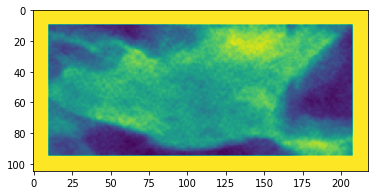

In [11]:
lesion = image[y:y+height, x:x+width]
plt.imshow(lesion)

In [129]:
# [STAR] For Transfer Learning of the model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

def myopen1(path):
    img = Image.open(path)
    img = img.resize((500, 750), Image.BICUBIC)
    img = np.array(img)
    img = np.expand_dims(img, 2)
    #img = img[]
    #img  = np.array(Image.open(path).convert("RGB"))
    #print(np.max(img), np.min(img))
    img  = img.astype('float')/60000.0
    img[img > 1] = 1
    img = img*255
    img = img.astype('uint8')
    #print(img.shape)
    img3 = np.concatenate([img, img, img], axis=2)
    return img3


data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        #transforms.RandomResizedCrop(224),
        #transforms.Resize((750, 500), interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/drilnvm/ubuntudata2/DBTexImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x], loader=myopen1) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [130]:
a, b = image_datasets['train'][10]
a = a.data.cpu().numpy()
#print(a.shape)
#a = a.data.numpy().cpu()
print(a.shape)

(3, 750, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


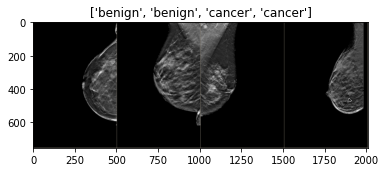

In [131]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    #print(np.max(inp.flatten()), np.min(inp.flatten()), inp.shape)
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [59]:
print(im2arr.dtype)

int32


(array([4.390578e+06, 5.019720e+05, 8.380340e+05, 2.052010e+05,
        3.828900e+04, 1.288600e+04, 6.070000e+03, 3.035000e+03,
        1.922000e+03, 2.013000e+03]),
 array([    0. ,  6540.8, 13081.6, 19622.4, 26163.2, 32704. , 39244.8,
        45785.6, 52326.4, 58867.2, 65408. ]),
 <BarContainer object of 10 artists>)

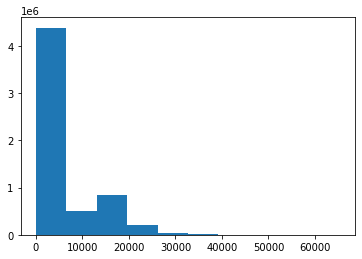

In [61]:
plt.hist(im2arr.flatten())

In [63]:
print(np.min(im2arr))

0
